In [ ]:
#@title **Initialize**
import sqlite3
con = sqlite3.connect('ClimberInfo.db')

import pandas as pd
from sklearn.datasets import make_blobs
import numpy as np
from numpy.random import default_rng

def query(sql_query_str, connection=con):
  df = None
  try:
    df = pd.read_sql_query(sql_query_str, connection).drop('index', axis=1)
  except:
    df = pd.read_sql_query(sql_query_str, connection)
  
  if len(df) <= 200:
    return df
  else:
    print('Pandas Memory Error: File is too big to keep in RAM!')
    raise

def save_query_to_csv(sql_query_str, output_file_name, connection=con):
  df = None
  try:
    df = pd.read_sql_query(sql_query_str, connection).drop('index', axis=1)
  except:
    df = pd.read_sql_query(sql_query_str, connection)

  df.to_csv(output_file_name)
  return output_file_name

def create_database():
  cluster_centers = np.array([ [25, 60], [25, 95], [50, 75], [50, 100], [40, 60], [35, 80]])
  blobs, labels = make_blobs(n_samples=200, n_features=2, centers=cluster_centers, cluster_std=[3, 3, 3, 3, 3, 3])
  blobs_as_dataframe = pd.DataFrame(data=blobs, columns=['Age', 'Weight'])
  ages = blobs_as_dataframe['Age']
  weights = blobs_as_dataframe['Weight']
  ages = ages.apply(lambda x: int(x))
  weights = weights.apply(lambda x: int(x))
  data = pd.DataFrame(data=np.array([ages, weights]).T, columns=['Age (Years)', 'Weight (kg)'])
  data['ID'] = data.index
  data_in = data[['ID', 'Age (Years)', 'Weight (kg)']]
  rng = default_rng()
  age_df = data_in[['ID', 'Age (Years)']]
  weight_df = data_in[['ID', 'Weight (kg)']]

  def create_noisey_weight_df(weight_df=weight_df):
    another_series = weight_df.apply(lambda row: str(row['ID']) + " " + str(row['Weight (kg)'] + rng.standard_normal() + rng.standard_normal()), axis=1)
    np_arr = another_series.to_numpy()
    good_arr = [x.split(' ') for x in np_arr]
    good_arr = [[int(a), float(b)] for a, b in good_arr]
    return pd.DataFrame(data=good_arr, columns=['ID', 'Weight (kg)'])
  
  hundred_noisey_weight_dfs = [create_noisey_weight_df() for i in range(100)]
  all_weights = pd.concat(hundred_noisey_weight_dfs)
  ages_to_keep, weights_to_keep = age_df, all_weights
  ages_to_keep.to_sql(name='Ages', con=con)
  weights_to_keep.to_sql(name='Weights', con=con)

create_database()
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

from math import sin

def best_climb(age, weight):
  return (abs(sin(age))*5 + abs(sin(weight))*7) % 10

def read_csv_into_spark_rdd(f):
  spark_df = sc.textFile(f)
  return spark_df.map(lambda x: (x.split(',')[1:]))

!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark
!wget -q https://student.cs.uwaterloo.ca/~cs451/content/cs431/p2p-Gnutella08-adj.txt
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf

spark_conf = SparkConf()\
  .setAppName("YourTest")\
  .setMaster("local[*]")

sc = SparkContext.getOrCreate(spark_conf)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


[('Ages',), ('Weights',)]


# **SQL Database** 

### **Tables** 

Ages 

Weights

### **Functions** 

query(*sql_query_str*) -> *Pandas DataFrame*

save_query_to_csv(*sql_query_str*, *file_name*) -> *Creates csv file for the query*
______________________________________

# **Spark** (Pretend we have access to a cluster of machines)

### **Functions**

read_csv_into_spark_rdd(*file_name*) -> *PySpark RDD*
______________________________________

# **Expert Climber**

### **Functions**

best_climb(*age_in_years*, *weight_in_kg*)

In [ ]:
# See, we can query ages like this
query('select * from Ages')

,ID,Age (Years)
0,0,22
1,1,45
2,2,24
3,3,34
4,4,27
...,...,...
195,195,50
196,196,22
197,197,46
198,198,23


In [ ]:
# And weights too... wait what?
query('select * from Weights')

Pandas Memory Error: File is too big to keep in RAM!


RuntimeError: ignored

In [ ]:
# Let's save the query in a csv, so that we can open it into a spark rdd and distribute it
save_query_to_csv('select * from Weights', 'raw_weights.csv')

'raw_weights.csv'

In [ ]:
# It converts each line to a list of strings, the first is the header
raw_rdd = read_csv_into_spark_rdd('raw_weights.csv')
raw_rdd.take(5)

[['ID', 'Weight (kg)'],
 ['0', '63.653994428238775'],
 ['1', '81.30075971067485'],
 ['2', '58.878690980327335'],
 ['3', '59.89367928959509']]

In [ ]:
# We're supposed to have the sane number of rows that the age table has...
raw_rdd.count()

20001

In [ ]:
# We'll look at just the data, converting the types
data = raw_rdd.filter(lambda x: x[0] != 'ID').map(lambda x: (int(x[0]), float(x[1])))
data.take(5)

[(0, 63.653994428238775),
 (1, 81.30075971067485),
 (2, 58.878690980327335),
 (3, 59.89367928959509),
 (4, 69.89952232696287)]

In [ ]:
# Let's group by the id, since we're only supposed to have 1 row for each id
grouped_by_id = data.groupByKey()
grouped_by_id.take(5)

[(0, <pyspark.resultiterable.ResultIterable at 0x7f9512ac6810>),
 (2, <pyspark.resultiterable.ResultIterable at 0x7f9512ac69d0>),
 (4, <pyspark.resultiterable.ResultIterable at 0x7f9512ac6750>),
 (6, <pyspark.resultiterable.ResultIterable at 0x7f9512ac65d0>),
 (8, <pyspark.resultiterable.ResultIterable at 0x7f9512ac6c50>)]

In [ ]:
# Oh my, we have many weights for a given id? How can one person have many different weights?
viewable_grouped = grouped_by_id.map(lambda x: (x[0], list(x[1])))
viewable_grouped.take(1)

[(0,
  [63.653994428238775,
   63.89706207324121,
   59.81643447221654,
   60.507363995559345,
   61.827780287138836,
   63.41228852196489,
   62.957481884474824,
   62.94791335184379,
   64.55853344576657,
   62.13753481469796,
   60.93039228667943,
   62.03467556441263,
   63.95645345355468,
   62.35776295120253,
   61.619675518518115,
   61.98337583535022,
   62.06734659967941,
   62.49682948878143,
   64.21909712949841,
   61.00008903676875,
   62.962775587257745,
   62.52117017475921,
   61.79249759572957,
   62.50403557626629,
   63.444540164579195,
   60.74720310013012,
   60.49237333282413,
   62.271231815065875,
   61.69215903726141,
   65.25201571372519,
   63.143309313777515,
   60.90977071944115,
   61.48028358945857,
   62.38002330970366,
   63.250944583876766,
   62.28164069928325,
   61.47226599485239,
   63.071838567023605,
   62.03835693911467,
   64.64973246344816,
   60.834379327210826,
   60.16524640969134,
   59.41846417351198,
   62.72807534115936,
   62.126244413

In [ ]:
# We call up the data entry specialist, and they say that the scale gives a hundred measurements instead of 1
# So we'll just average the results
averaged = viewable_grouped.map(lambda x: (x[0], sum(x[1]) / len(x[1])))
averaged.take(5)

[(0, 62.03442941511084),
 (2, 59.862905777171875),
 (4, 68.81420067473469),
 (6, 98.97440415437588),
 (8, 81.07545662269216)]

In [ ]:
# It's actually slow to use a groupBy, and we could use a reduceBy, but since it was quick we'll let it go...
# If there was more data then we should check out how to do the average with reduceBy
# We're happy with this rdd so we'll call it weights_rdd
weights_rdd = averaged

In [ ]:
# It's easier to compare apples to apples, so we'll do the same process with the ages table
save_query_to_csv('select * from Ages', 'raw_ages.csv')

'raw_ages.csv'

In [ ]:
ages_rdd = read_csv_into_spark_rdd('raw_ages.csv')
ages_rdd.take(5)

[['ID', 'Age (Years)'], ['0', '22'], ['1', '45'], ['2', '24'], ['3', '34']]

In [ ]:
# Again get rid of the header and convert the data types
ages_rdd = ages_rdd.filter(lambda x: x[0] != 'ID').map(lambda x: (int(x[0]), int(x[1])))
ages_rdd.take(5)

[(0, 22), (1, 45), (2, 24), (3, 34), (4, 27)]

In [ ]:
# Now we'll join them, and the RDDs so that the age and averaged weight match up to their id
id_age_weight_rdd = ages_rdd.join(weights_rdd).map(lambda x: (x[0], x[1][0], x[1][1]))
id_age_weight_rdd.take(5)

[(0, 22, 62.03442941511084),
 (4, 27, 68.81420067473469),
 (8, 33, 81.07545662269216),
 (12, 38, 78.07901288911441),
 (16, 27, 59.339614946066405)]

In [ ]:
# And just to be sure it's only 200 rows
id_age_weight_rdd.count()

200

In [ ]:
# Let's bring this information back to the driver node since we know it's only 200 rows now
collected = id_age_weight_rdd.collect()
collected[:5]

[(0, 22, 62.03442941511084),
 (4, 27, 68.81420067473469),
 (8, 33, 81.07545662269216),
 (12, 38, 78.07901288911441),
 (16, 27, 59.339614946066405)]

In [ ]:
# Let's convert our information into a Pandas DataFrame
good_pd_df = pd.DataFrame(collected, columns=['ID', 'Age_in_years', 'Weight_in_kg'])
good_pd_df

,ID,Age_in_years,Weight_in_kg
0,0,22,62.034429
1,4,27,68.814201
2,8,33,81.075457
3,12,38,78.079013
4,16,27,59.339615
...,...,...,...
195,183,39,81.778118
196,187,36,79.162725
197,191,19,60.833521
198,195,50,69.798185


In [ ]:
# And just so we don't lose our work, we'll save the Pandas DataFrame
# so that we can say goodbye to Spark for the rest of the project!
good_pd_df.to_pickle('id_age_weight_combined.pkl')

In [ ]:
good_pd_df = pd.read_pickle('id_age_weight_combined.pkl')
good_pd_df

,ID,Age_in_years,Weight_in_kg
0,0,22,62.034429
1,4,27,68.814201
2,8,33,81.075457
3,12,38,78.079013
4,16,27,59.339615
...,...,...,...
195,183,39,81.778118
196,187,36,79.162725
197,191,19,60.833521
198,195,50,69.798185


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f950e2b89d0>,
      dtype=object)

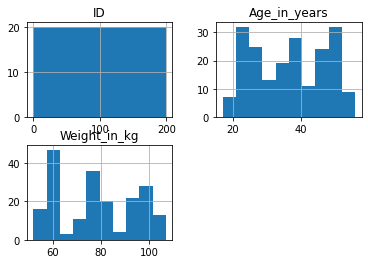

In [ ]:
# As usual, we'll inspect the data
good_pd_df.hist()

In [ ]:
# Don't see anything problematic here
good_pd_df.describe()

,ID,Age_in_years,Weight_in_kg
count,200.000000,200.000000,200.000000
mean,99.500000,36.665000,78.023038
std,57.879185,10.827695,15.935706
min,0.000000,17.000000,52.115966
25%,49.750000,26.000000,61.080505
50%,99.500000,37.000000,77.532047
75%,149.250000,47.000000,94.808340
max,199.000000,56.000000,106.803957


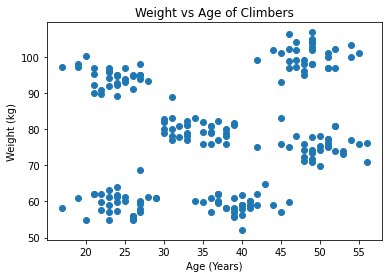

In [ ]:
# We'll make a simple scatterplot of the data
import matplotlib.pyplot as plt
ages = good_pd_df['Age_in_years']
weights = good_pd_df['Weight_in_kg']
plt.scatter(ages, weights)
plt.xlabel('Age (Years)')
plt.ylabel('Weight (kg)')
plt.title('Weight vs Age of Climbers')
plt.show()

In [ ]:
# We'll convert our data to a NumPy array for more complicated processing
prepared_data = np.array([ages, weights]).T
prepared_data[:5]

array([[22.        , 62.03442942],
       [27.        , 68.81420067],
       [33.        , 81.07545662],
       [38.        , 78.07901289],
       [27.        , 59.33961495]])

In [ ]:
# Fit the clustering model, and show the centers of the groups!
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=6)
kmeans_model.fit(prepared_data)
cluster_centers = kmeans_model.cluster_centers_
cluster_centers

array([[ 48.57575758, 100.26801663],
       [ 34.21212121,  79.71071308],
       [ 39.47058824,  59.11763461],
       [ 23.79411765,  94.28376542],
       [ 24.27272727,  59.59496048],
       [ 49.96969697,  75.24327954]])

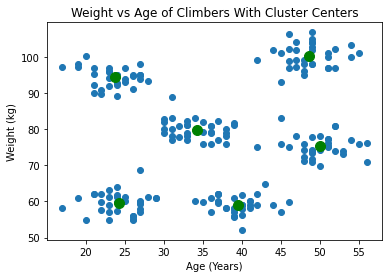

In [ ]:
# We'll add the cluster centers to the plotted data
ages = good_pd_df['Age_in_years']
weights = good_pd_df['Weight_in_kg']
plt.scatter(ages, weights)
plt.xlabel('Age (Years)')
plt.ylabel('Weight (kg)')
plt.title('Weight vs Age of Climbers With Cluster Centers')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='green', s=100)
plt.show()

In [ ]:
# The clustering model assigned labels to each point!
labels = kmeans_model.labels_
labels

array([4, 4, 1, 1, 4, 2, 3, 5, 4, 1, 0, 3, 2, 1, 1, 3, 2, 2, 0, 5, 5, 0,
       0, 3, 0, 1, 2, 1, 3, 4, 3, 0, 3, 4, 5, 5, 1, 0, 3, 5, 2, 0, 5, 1,
       4, 4, 3, 0, 4, 3, 5, 4, 2, 1, 4, 1, 3, 1, 0, 2, 1, 1, 0, 3, 2, 0,
       4, 2, 0, 5, 1, 5, 0, 4, 4, 5, 3, 3, 0, 5, 3, 3, 3, 1, 1, 5, 5, 2,
       1, 5, 3, 4, 3, 5, 1, 0, 3, 5, 0, 0, 4, 0, 2, 2, 0, 4, 3, 5, 1, 0,
       1, 0, 5, 2, 2, 4, 3, 1, 0, 2, 4, 1, 1, 4, 1, 4, 4, 3, 0, 2, 2, 2,
       0, 3, 4, 3, 2, 1, 2, 1, 5, 4, 3, 0, 3, 0, 5, 2, 3, 4, 2, 4, 5, 5,
       2, 2, 1, 2, 5, 2, 3, 3, 3, 5, 2, 0, 1, 4, 1, 4, 0, 1, 3, 0, 0, 5,
       2, 5, 5, 2, 2, 0, 3, 5, 4, 0, 3, 4, 2, 5, 2, 2, 4, 5, 4, 1, 1, 4,
       5, 5], dtype=int32)

In [ ]:
# We'll append this a a column to our pandas DataFrame
final_pd_df = good_pd_df
final_pd_df['Cluster'] = pd.Series(labels)
final_pd_df

,ID,Age_in_years,Weight_in_kg,Cluster
0,0,22,62.034429,4
1,4,27,68.814201,4
2,8,33,81.075457,1
3,12,38,78.079013,1
4,16,27,59.339615,4
...,...,...,...,...
195,183,39,81.778118,1
196,187,36,79.162725,1
197,191,19,60.833521,4
198,195,50,69.798185,5


In [ ]:
# We'll again want this in NumPy for a slightly more complicated graph
# where we need to assign each point a colour based on its label
final_as_np = final_pd_df.to_numpy()
final_as_np[:5]

array([[ 0.        , 22.        , 62.03442942,  4.        ],
       [ 4.        , 27.        , 68.81420067,  4.        ],
       [ 8.        , 33.        , 81.07545662,  1.        ],
       [12.        , 38.        , 78.07901289,  1.        ],
       [16.        , 27.        , 59.33961495,  4.        ]])

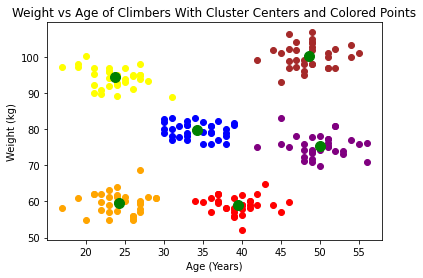

In [ ]:
# We use this list of colours and look up the colour for each point
# based on the label
colors = ['brown', 'blue', 'red', 'yellow', 'orange', 'purple']

for row in final_as_np:
  x = row[1]
  y = row[2]
  label = row[3]
  color = colors[int(label)]
  plt.scatter(x, y, color=color)

plt.xlabel('Age (Years)')
plt.ylabel('Weight (kg)')
plt.title('Weight vs Age of Climbers With Cluster Centers and Colored Points')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='green', s=100)
plt.show()

In [ ]:
# We ask the expert what the best climb is for each of the cluster centers
climb_difficulties = [best_climb(x, y) for x, y in cluster_centers]
climb_difficulties

[6.784182001751308,
 8.140556541347603,
 8.69254222985876,
 5.117690125798475,
 4.455348566529955,
 2.53773099697733]

In [ ]:
# And we'll add a final column to the DataFrame what their best climb is based
# on what group they were in
correct_climbs = final_pd_df['Cluster'].apply(lambda x: climb_difficulties[x])
correct_climbs

0      4.455349
1      4.455349
2      8.140557
3      8.140557
4      4.455349
         ...   
195    8.140557
196    8.140557
197    4.455349
198    2.537731
199    2.537731
Name: Cluster, Length: 200, dtype: float64

In [ ]:
final_pd_df['Best Climb'] = correct_climbs
final_pd_df

,ID,Age_in_years,Weight_in_kg,Cluster,Best Climb
0,0,22,62.034429,4,4.455349
1,4,27,68.814201,4,4.455349
2,8,33,81.075457,1,8.140557
3,12,38,78.079013,1,8.140557
4,16,27,59.339615,4,4.455349
...,...,...,...,...,...
195,183,39,81.778118,1,8.140557
196,187,36,79.162725,1,8.140557
197,191,19,60.833521,4,4.455349
198,195,50,69.798185,5,2.537731


In [ ]:
# Here's the function that we'll invoke when they step into the gym
def best_climb_given_id(id, df=final_pd_df):
  return df[df['ID'] == id]['Best Climb']

In [ ]:
best_climb_given_id(4)

1    4.455349
Name: Best Climb, dtype: float64